# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=79,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5071 | MulticlassF1Score=0.0762
Batch-30 : CrossEntropyLoss=2.4621 | MulticlassF1Score=0.1621
Batch-45 : CrossEntropyLoss=2.4872 | MulticlassF1Score=0.1945
Batch-60 : CrossEntropyLoss=2.4590 | MulticlassF1Score=0.2136
Batch-75 : CrossEntropyLoss=2.4444 | MulticlassF1Score=0.2353
Batch-90 : CrossEntropyLoss=2.4406 | MulticlassF1Score=0.2582
Batch-105: CrossEntropyLoss=2.4384 | MulticlassF1Score=0.2736
Batch-120: CrossEntropyLoss=2.4452 | MulticlassF1Score=0.2866
Batch-135: CrossEntropyLoss=2.4388 | MulticlassF1Score=0.2973
Batch-150: CrossEntropyLoss=2.4054 | MulticlassF1Score=0.3099
Batch-165: CrossEntropyLoss=2.3929 | MulticlassF1Score=0.3244
Batch-180: CrossEntropyLoss=2.3852 | MulticlassF1Score=0.3435
Batch-195: CrossEntropyLoss=2.3748 | MulticlassF1Score=0.3617
Batch-210: CrossEntropyLoss=2.3563 | MulticlassF1Score=0.3775
Batch-225: CrossEntropyLoss=2.3795 | MulticlassF1Score=0.3921
Batch-226: CrossEntropyLoss=2.3734 | MulticlassF1Score=0.3927

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3922 | MulticlassF1Score=0.5811
Batch-30 : CrossEntropyLoss=2.3951 | MulticlassF1Score=0.5850
Batch-45 : CrossEntropyLoss=2.3585 | MulticlassF1Score=0.5856
Batch-60 : CrossEntropyLoss=2.3699 | MulticlassF1Score=0.5844
Batch-63 : CrossEntropyLoss=2.3844 | MulticlassF1Score=0.5833

Training   : Mean CrossEntropyLoss = 2.4453 | Mean MulticlassF1Score = 0.2640
Validation : Mean CrossEntropyLoss = 2.3767 | Mean MulticlassF1Score = 0.5837

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3692 | MulticlassF1Score=0.5880
Batch-30 : CrossEntropyLoss=2.3632 | MulticlassF1Score=0.6020
Batch-45 : CrossEntropyLoss=2.3595 | MulticlassF1Score=0.6176
Batch-60 : CrossEntropyLoss=2.3495 | MulticlassF1Score=0.6283
Batch-75 : CrossEntropyLoss=2.3321 | MulticlassF1Score=0.6452
Batch-90 : CrossEntropyLoss=2.3214 | MulticlassF1Score=0.6613
Batch-105: CrossEntropyLoss=2.3213 | MulticlassF1Score=0.6778
Batch-120: CrossEntropyLoss=2.3176 | MulticlassF1Score=0.6900
Batch-135: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7002
Batch-150: CrossEntropyLoss=2.3311 | MulticlassF1Score=0.7086
Batch-165: CrossEntropyLoss=2.3191 | MulticlassF1Score=0.7154
Batch-180: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7205
Batch-195: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7258
Batch-210: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.7305
Batch-225: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7349
Batch-226: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.7352

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7953
Batch-30 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7931
Batch-45 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.7934
Batch-60 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.7943
Batch-63 : CrossEntropyLoss=2.3279 | MulticlassF1Score=0.7934

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3312 | Mean MulticlassF1Score = 0.6715
Validation : Mean CrossEntropyLoss = 2.3123 | Mean MulticlassF1Score = 0.7945

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.7996
Batch-30 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8018
Batch-45 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8017
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8022
Batch-75 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8028
Batch-90 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8011
Batch-105: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8022
Batch-120: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8018
Batch-135: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8016
Batch-150: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.8013
Batch-165: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8017
Batch-180: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8012
Batch-195: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8013
Batch-210: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.8012
Batch-225: CrossEntropyLoss=2.3142 | MulticlassF1Score=0.8016
Batch-226: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.8015

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3193 | MulticlassF1Score=0.8050
Batch-30 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8003
Batch-45 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7997
Batch-60 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7982
Batch-63 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.7986

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3097 | Mean MulticlassF1Score = 0.8015
Validation : Mean CrossEntropyLoss = 2.3099 | Mean MulticlassF1Score = 0.8014

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8013
Batch-30 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8038
Batch-45 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8027
Batch-60 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8034
Batch-75 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8041
Batch-90 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8039
Batch-105: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8040
Batch-120: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8042
Batch-135: CrossEntropyLoss=2.3180 | MulticlassF1Score=0.8037
Batch-150: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8037
Batch-165: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8039
Batch-180: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8043
Batch-195: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8050
Batch-210: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8053
Batch-225: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.8054
Batch-226: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8054

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8002
Batch-30 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8023
Batch-45 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8009
Batch-60 : CrossEntropyLoss=2.3159 | MulticlassF1Score=0.8015
Batch-63 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8013

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3081 | Mean MulticlassF1Score = 0.8037
Validation : Mean CrossEntropyLoss = 2.3090 | Mean MulticlassF1Score = 0.8016

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8100
Batch-30 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8079
Batch-45 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8076
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8116
Batch-75 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8146
Batch-90 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8164
Batch-105: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8176
Batch-120: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8190
Batch-135: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8206
Batch-150: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8212
Batch-165: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8218
Batch-180: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8224
Batch-195: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8225
Batch-210: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8228
Batch-225: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8233
Batch-226: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.8232

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8166
Batch-30 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8196
Batch-45 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8213
Batch-60 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8215
Batch-63 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8220

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3025 | Mean MulticlassF1Score = 0.8169
Validation : Mean CrossEntropyLoss = 2.3026 | Mean MulticlassF1Score = 0.8185

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8340
Batch-30 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8344
Batch-45 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8372
Batch-60 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8391
Batch-75 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8386
Batch-90 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8384
Batch-105: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8397
Batch-120: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8401
Batch-135: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8401
Batch-150: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8402
Batch-165: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.8399
Batch-180: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8405
Batch-195: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8406
Batch-210: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8401
Batch-225: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8400
Batch-226: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.8399

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8405
Batch-30 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8331
Batch-45 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8336
Batch-60 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8336
Batch-63 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8335

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2974 | Mean MulticlassF1Score = 0.8385
Validation : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8379

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8458
Batch-30 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8458
Batch-45 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8421
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8415
Batch-75 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8426
Batch-90 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8417
Batch-105: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8417
Batch-120: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8424
Batch-135: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8451
Batch-150: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8473
Batch-165: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8492
Batch-180: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8507
Batch-195: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8520
Batch-210: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8535
Batch-225: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8539
Batch-226: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8540

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8650
Batch-30 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8636
Batch-45 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8629
Batch-60 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8617
Batch-63 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8618

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8458
Validation : Mean CrossEntropyLoss = 2.2906 | Mean MulticlassF1Score = 0.8636

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8694
Batch-30 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8699
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8735
Batch-60 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8724
Batch-75 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8730
Batch-90 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8724
Batch-105: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8722
Batch-120: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8716
Batch-135: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8714
Batch-150: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8718
Batch-165: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8715
Batch-180: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8726
Batch-195: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8738
Batch-210: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8745
Batch-225: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8756
Batch-226: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8756

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8812
Batch-30 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8795
Batch-45 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8783
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8792
Batch-63 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8795

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2865 | Mean MulticlassF1Score = 0.8721
Validation : Mean CrossEntropyLoss = 2.2854 | Mean MulticlassF1Score = 0.8801

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8923
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8908
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8921
Batch-60 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8914
Batch-75 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8916
Batch-90 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8911
Batch-105: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8912
Batch-120: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8917
Batch-135: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8915
Batch-150: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8910
Batch-165: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8904
Batch-180: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8906
Batch-195: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8903
Batch-210: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8898
Batch-225: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8898
Batch-226: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8898

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8801
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8809
Batch-45 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8822
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8815
Batch-63 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8819

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8912
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8818

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8957
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8944
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8925
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8917
Batch-75 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8918
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8914
Batch-105: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8920
Batch-120: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8922
Batch-135: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8922
Batch-150: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8925
Batch-165: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8924
Batch-180: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8923
Batch-195: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8926
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8925
Batch-225: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8926
Batch-226: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8926

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8822
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8813
Batch-45 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8819
Batch-60 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8834
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8834

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8925
Validation : Mean CrossEntropyLoss = 2.2837 | Mean MulticlassF1Score = 0.8823

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8948
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8951
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8968
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8964
Batch-75 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8972
Batch-90 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8967
Batch-105: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8968
Batch-120: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8967
Batch-135: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8954
Batch-150: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8949
Batch-165: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8944
Batch-180: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8945
Batch-195: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8945
Batch-210: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8947
Batch-225: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8945
Batch-226: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8945

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8853
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8880
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8873
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8854
Batch-63 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8846

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8958
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8866

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8957
Batch-30 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8944
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8928
Batch-60 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8914
Batch-75 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8925
Batch-90 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8942
Batch-105: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8940
Batch-120: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8936
Batch-135: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8943
Batch-150: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.8945
Batch-165: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8950
Batch-180: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8953
Batch-195: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8954
Batch-210: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8954
Batch-225: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8955
Batch-226: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8956

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8811
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8858
Batch-45 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8856
Batch-60 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8852
Batch-63 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8847

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8941
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8826

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8970
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8964
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8955
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8973
Batch-75 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8980
Batch-90 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8975
Batch-105: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8975
Batch-120: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8973
Batch-135: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8973
Batch-150: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8972
Batch-165: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8969
Batch-180: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8966
Batch-195: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8963
Batch-210: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8965
Batch-225: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8968
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.8969

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8847
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8862
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8841
Batch-60 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8845
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8845

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8972
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8861

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8977
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8976
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8976
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8982
Batch-75 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8982
Batch-90 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8978
Batch-105: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8986
Batch-120: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8982
Batch-135: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8980
Batch-150: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8981
Batch-165: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8980
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8983
Batch-195: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8982
Batch-210: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8982
Batch-225: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8981
Batch-226: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8981

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8753
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8834
Batch-45 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8849
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8844
Batch-63 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8841

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2792 | Mean MulticlassF1Score = 0.8979
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8811

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8997
Batch-30 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8972
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8986
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8991
Batch-75 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8994
Batch-90 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9000
Batch-105: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9000
Batch-120: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8987
Batch-135: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8989
Batch-150: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.8994
Batch-165: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8994
Batch-180: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.8996
Batch-195: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8995
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8995
Batch-225: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8994
Batch-226: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8994

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8873
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8882
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8864
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8859
Batch-63 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8857

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2788 | Mean MulticlassF1Score = 0.8992
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8870

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9016
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8988
Batch-45 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8994
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9001
Batch-75 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8998
Batch-90 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8999
Batch-105: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9001
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9004
Batch-135: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9005
Batch-150: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9006
Batch-165: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9004
Batch-180: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8999
Batch-195: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9000
Batch-210: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9003
Batch-225: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9003
Batch-226: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9003

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8839
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8875
Batch-45 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8876
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8863
Batch-63 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8862

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.8999
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8869

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9070
Batch-30 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9032
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9034
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9024
Batch-75 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9033
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9030
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9026
Batch-120: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9020
Batch-135: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9018
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9017
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9010
Batch-180: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9029
Batch-195: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9043
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9055
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9069
Batch-226: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9070

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9093
Batch-30 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.9080
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9098
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9103
Batch-63 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9100

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9035
Validation : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9087

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9288
Batch-75 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9286
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9297
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9304
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9305
Batch-135: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9309
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9309
Batch-165: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9311
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9308
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9314
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9318
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9319
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9319

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9216
Batch-45 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.9197
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9194
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9195

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9297
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9210

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9321
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9345
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9347
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9349
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9349
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9342
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9341
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9338
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9345
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9348
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9350
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9350
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9349
Batch-210: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9346
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9348
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9348

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9188
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9195
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9196

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2678 | Mean MulticlassF1Score = 0.9346
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9201

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9360
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9366
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9369
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9374
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9371
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9369
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9372
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9377
Batch-165: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9371
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9365
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9366
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9367
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9363
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9362

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9174
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9168
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9197
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9198
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9203

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9369
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9188

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9392
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9389
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9380
Batch-105: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9374
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9368
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9370
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9373
Batch-225: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9373
Batch-226: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9372

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9204
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9211

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9384
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9211

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9370
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9383
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9395
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9408
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9407
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9409
Batch-135: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9412
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9413
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9410
Batch-195: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9409
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9406
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9406

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9227

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9403
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9241

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9418
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9416
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9415
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9414
Batch-165: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9224

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9417
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9233

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9422
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9421
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9431
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9426
Batch-165: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9421
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9420
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9423
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9422
Batch-226: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9238
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9240

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9423
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9248

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9418
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9418
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9424
Batch-75 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9424
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9431
Batch-105: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9434
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9437
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9435
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9432
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9433
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9430
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9227
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9232

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9431
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9226

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9421
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9429
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9429
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9434
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9435
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9436
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9436

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9206
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9241

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9234

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9453
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9451
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9441
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9440
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9438
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9438

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9239

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9251

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9428
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9433
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9440
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9443
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9444
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9446
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9272
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9262

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9442
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9273

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9460
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9459
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9282
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9259

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9271

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9470
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9471
Batch-90 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9469
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9468
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9465
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9261

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9286
Patience = 1/50‚ùó

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9462
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9463
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9473
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9471
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9471
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9468
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9264

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9464
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9263

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9464
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9476
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9480
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9475
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9479
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9491
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9501
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9512
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9518
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9518

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9448

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2624 | Mean MulticlassF1Score = 0.9476
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9452

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9649
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9664
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9669
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9670
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9458

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9453

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9456
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9456

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9469

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9470

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9465

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9741
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9693
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9466

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9479

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9687
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9688
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9464

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9461

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9713
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9696
Batch-75 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9465

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9485

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9464

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9481

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9730
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2518 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9460

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9462
Patience = 2/50‚ùó

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9682
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9477

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9477

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9713
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9477

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9490

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9702
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9702
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9698
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9698

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9487

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9703
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9482

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9718
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9712
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9707
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9705

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9476

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9488

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9711
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9707
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9708

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9481

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9458

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9726
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9721
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9719
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9715
Batch-90 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9714
Batch-120: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9717
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9718
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9719
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9487

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9475

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9707
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9717
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9717
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9717
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9716
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9510
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9484

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9489

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9728
Batch-30 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9730
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9717
Batch-180: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9719
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9718
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9488

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9497

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9731
Batch-30 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9738
Batch-45 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9736
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9727
Batch-75 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9726
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9723
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9721
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9725
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9725
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9724
Batch-165: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9723
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9721
Batch-210: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9720
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9718
Batch-226: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9490

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9727
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9503

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9707
Batch-30 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9726
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9724
Batch-60 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9723
Batch-75 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9730
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9725
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9723
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9722
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9722
Batch-150: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9722
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9723
Batch-195: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9722
Batch-210: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9725
Batch-225: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9723
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9723

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9490

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2559 | Mean MulticlassF1Score = 0.9723
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9496

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2559
Best CrossEntropyLoss training    : 2.2632
Best MulticlassF1Score validation : 0.9723
Best MulticlassF1Score validation : 0.9496
Training duration                 : 2.7852 minutes.
Training date                     : 2022-10-19 14:46:44.731655+08:00


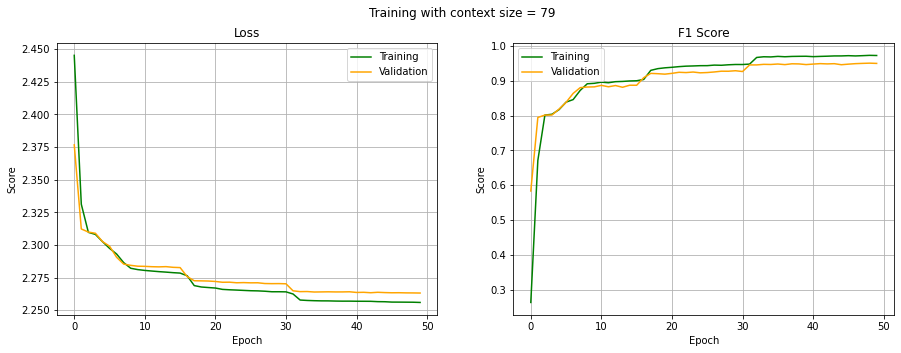

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9726, device='cuda:0'),
 tensor(0.9490, device='cuda:0'),
 tensor(0.9482, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9726, device='cuda:0'),
 tensor(0.9490, device='cuda:0'),
 tensor(0.9482, device='cuda:0'))

## Heatmap

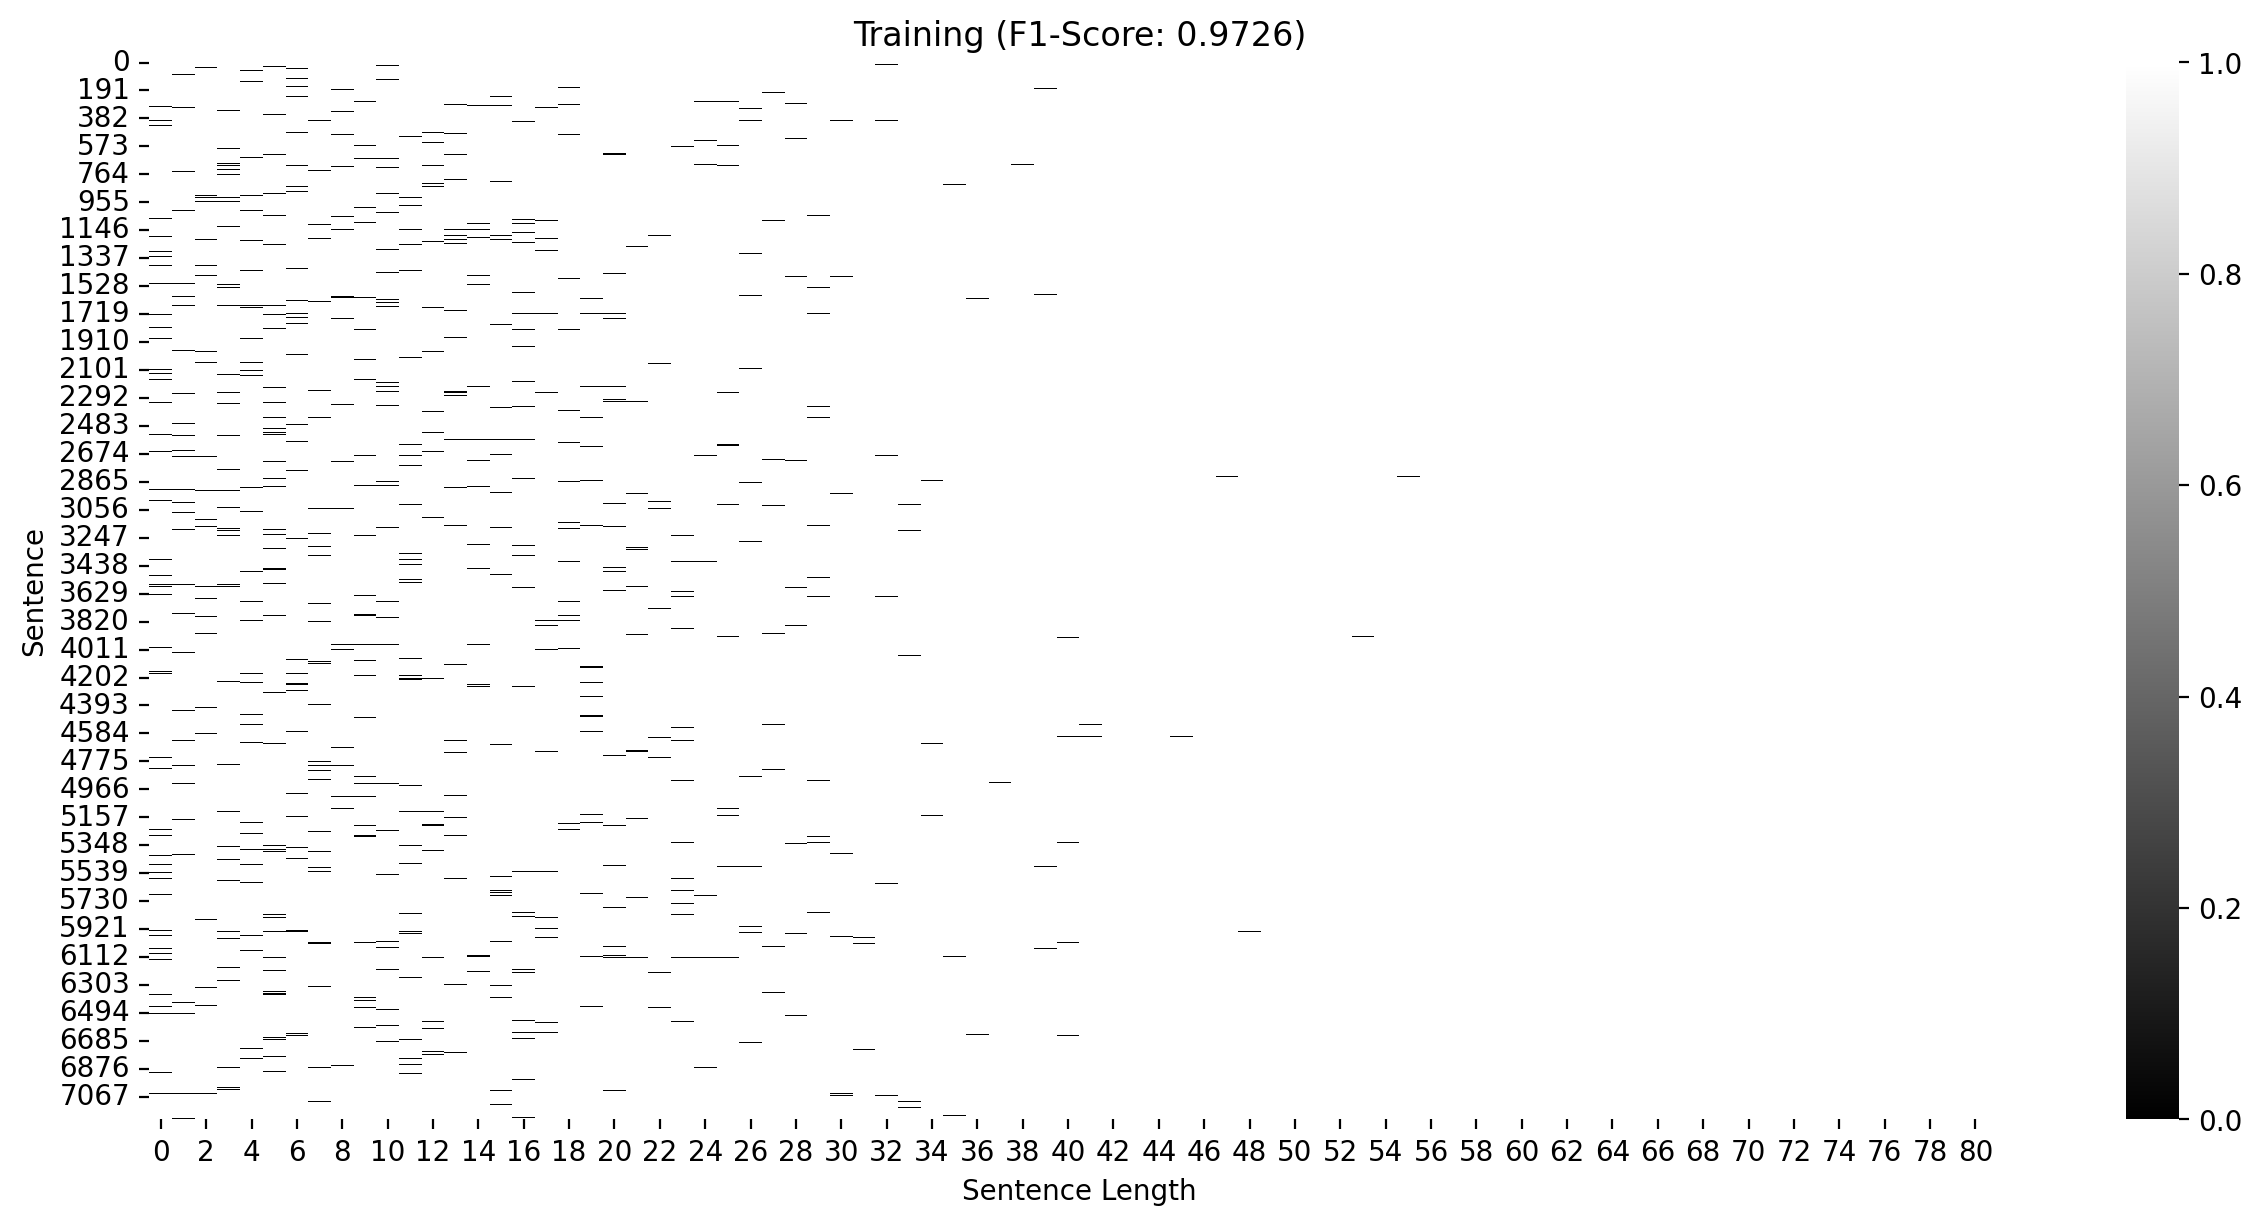

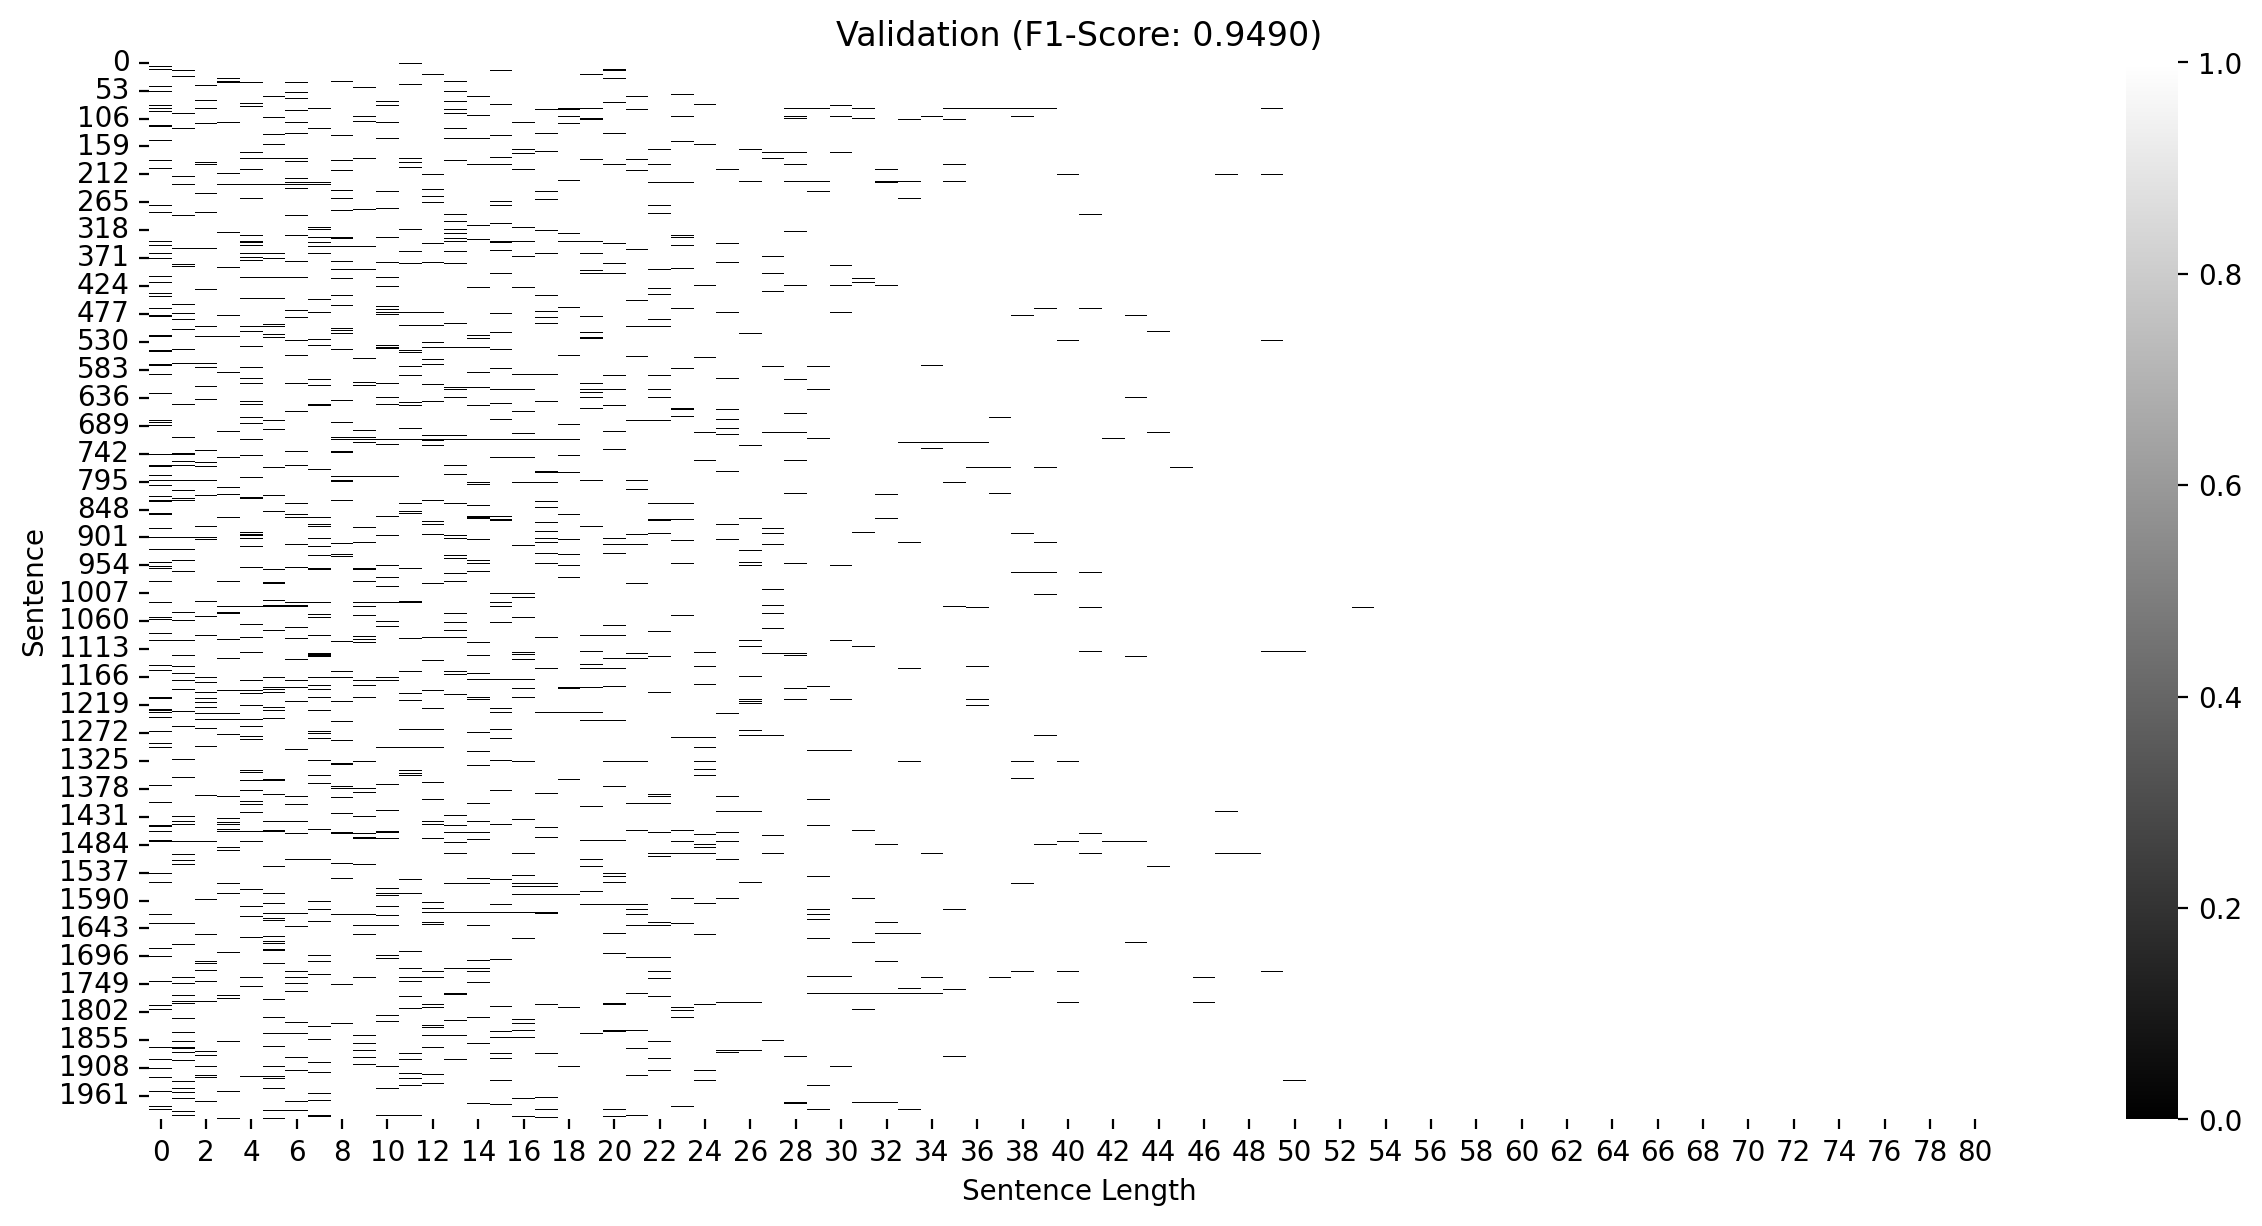

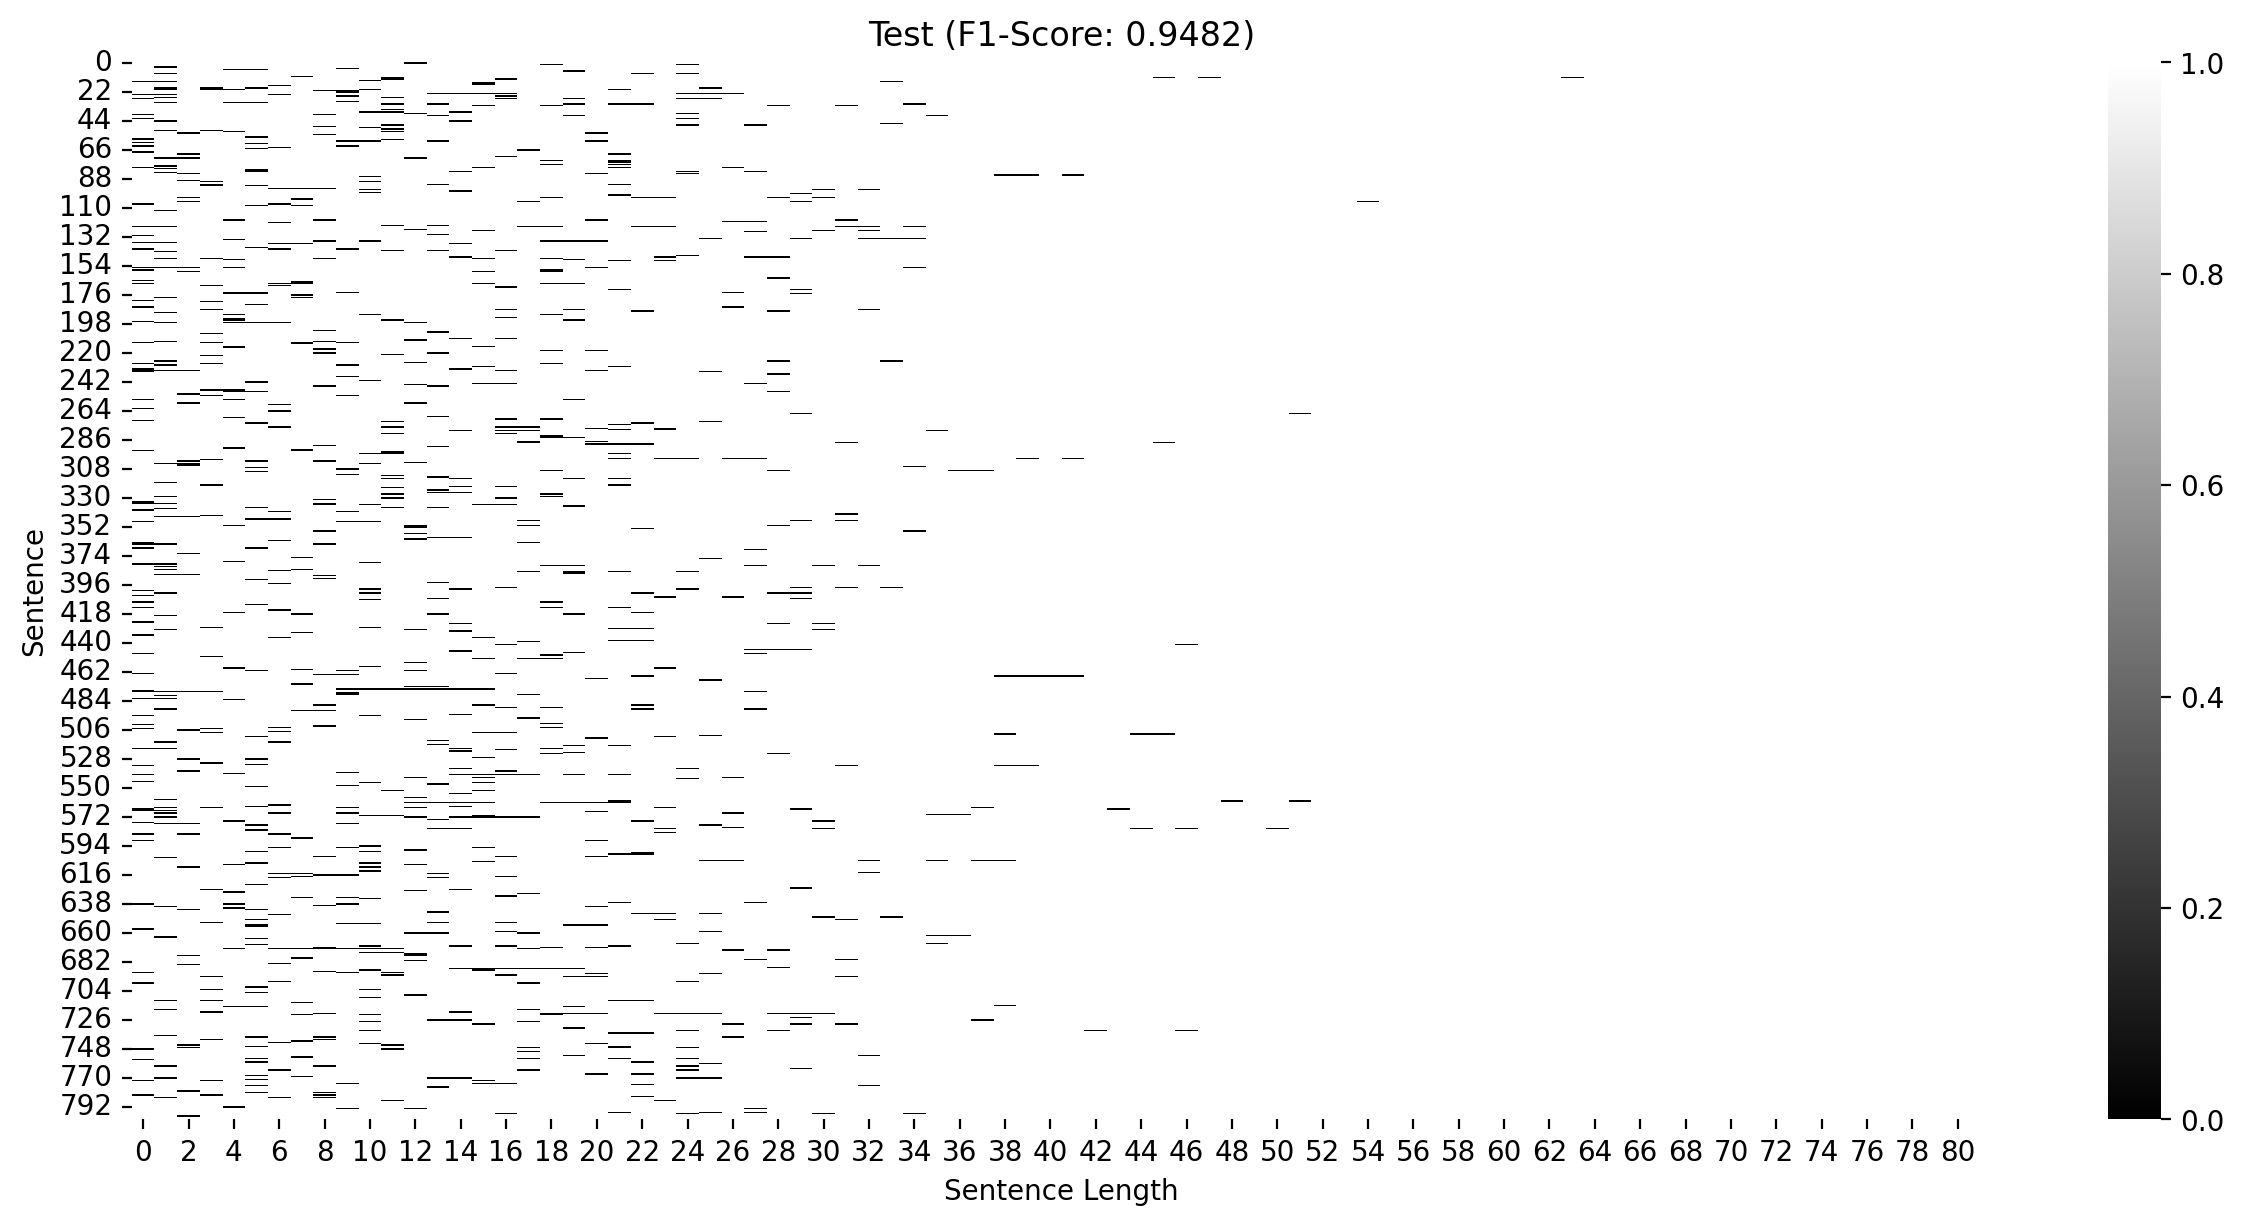

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


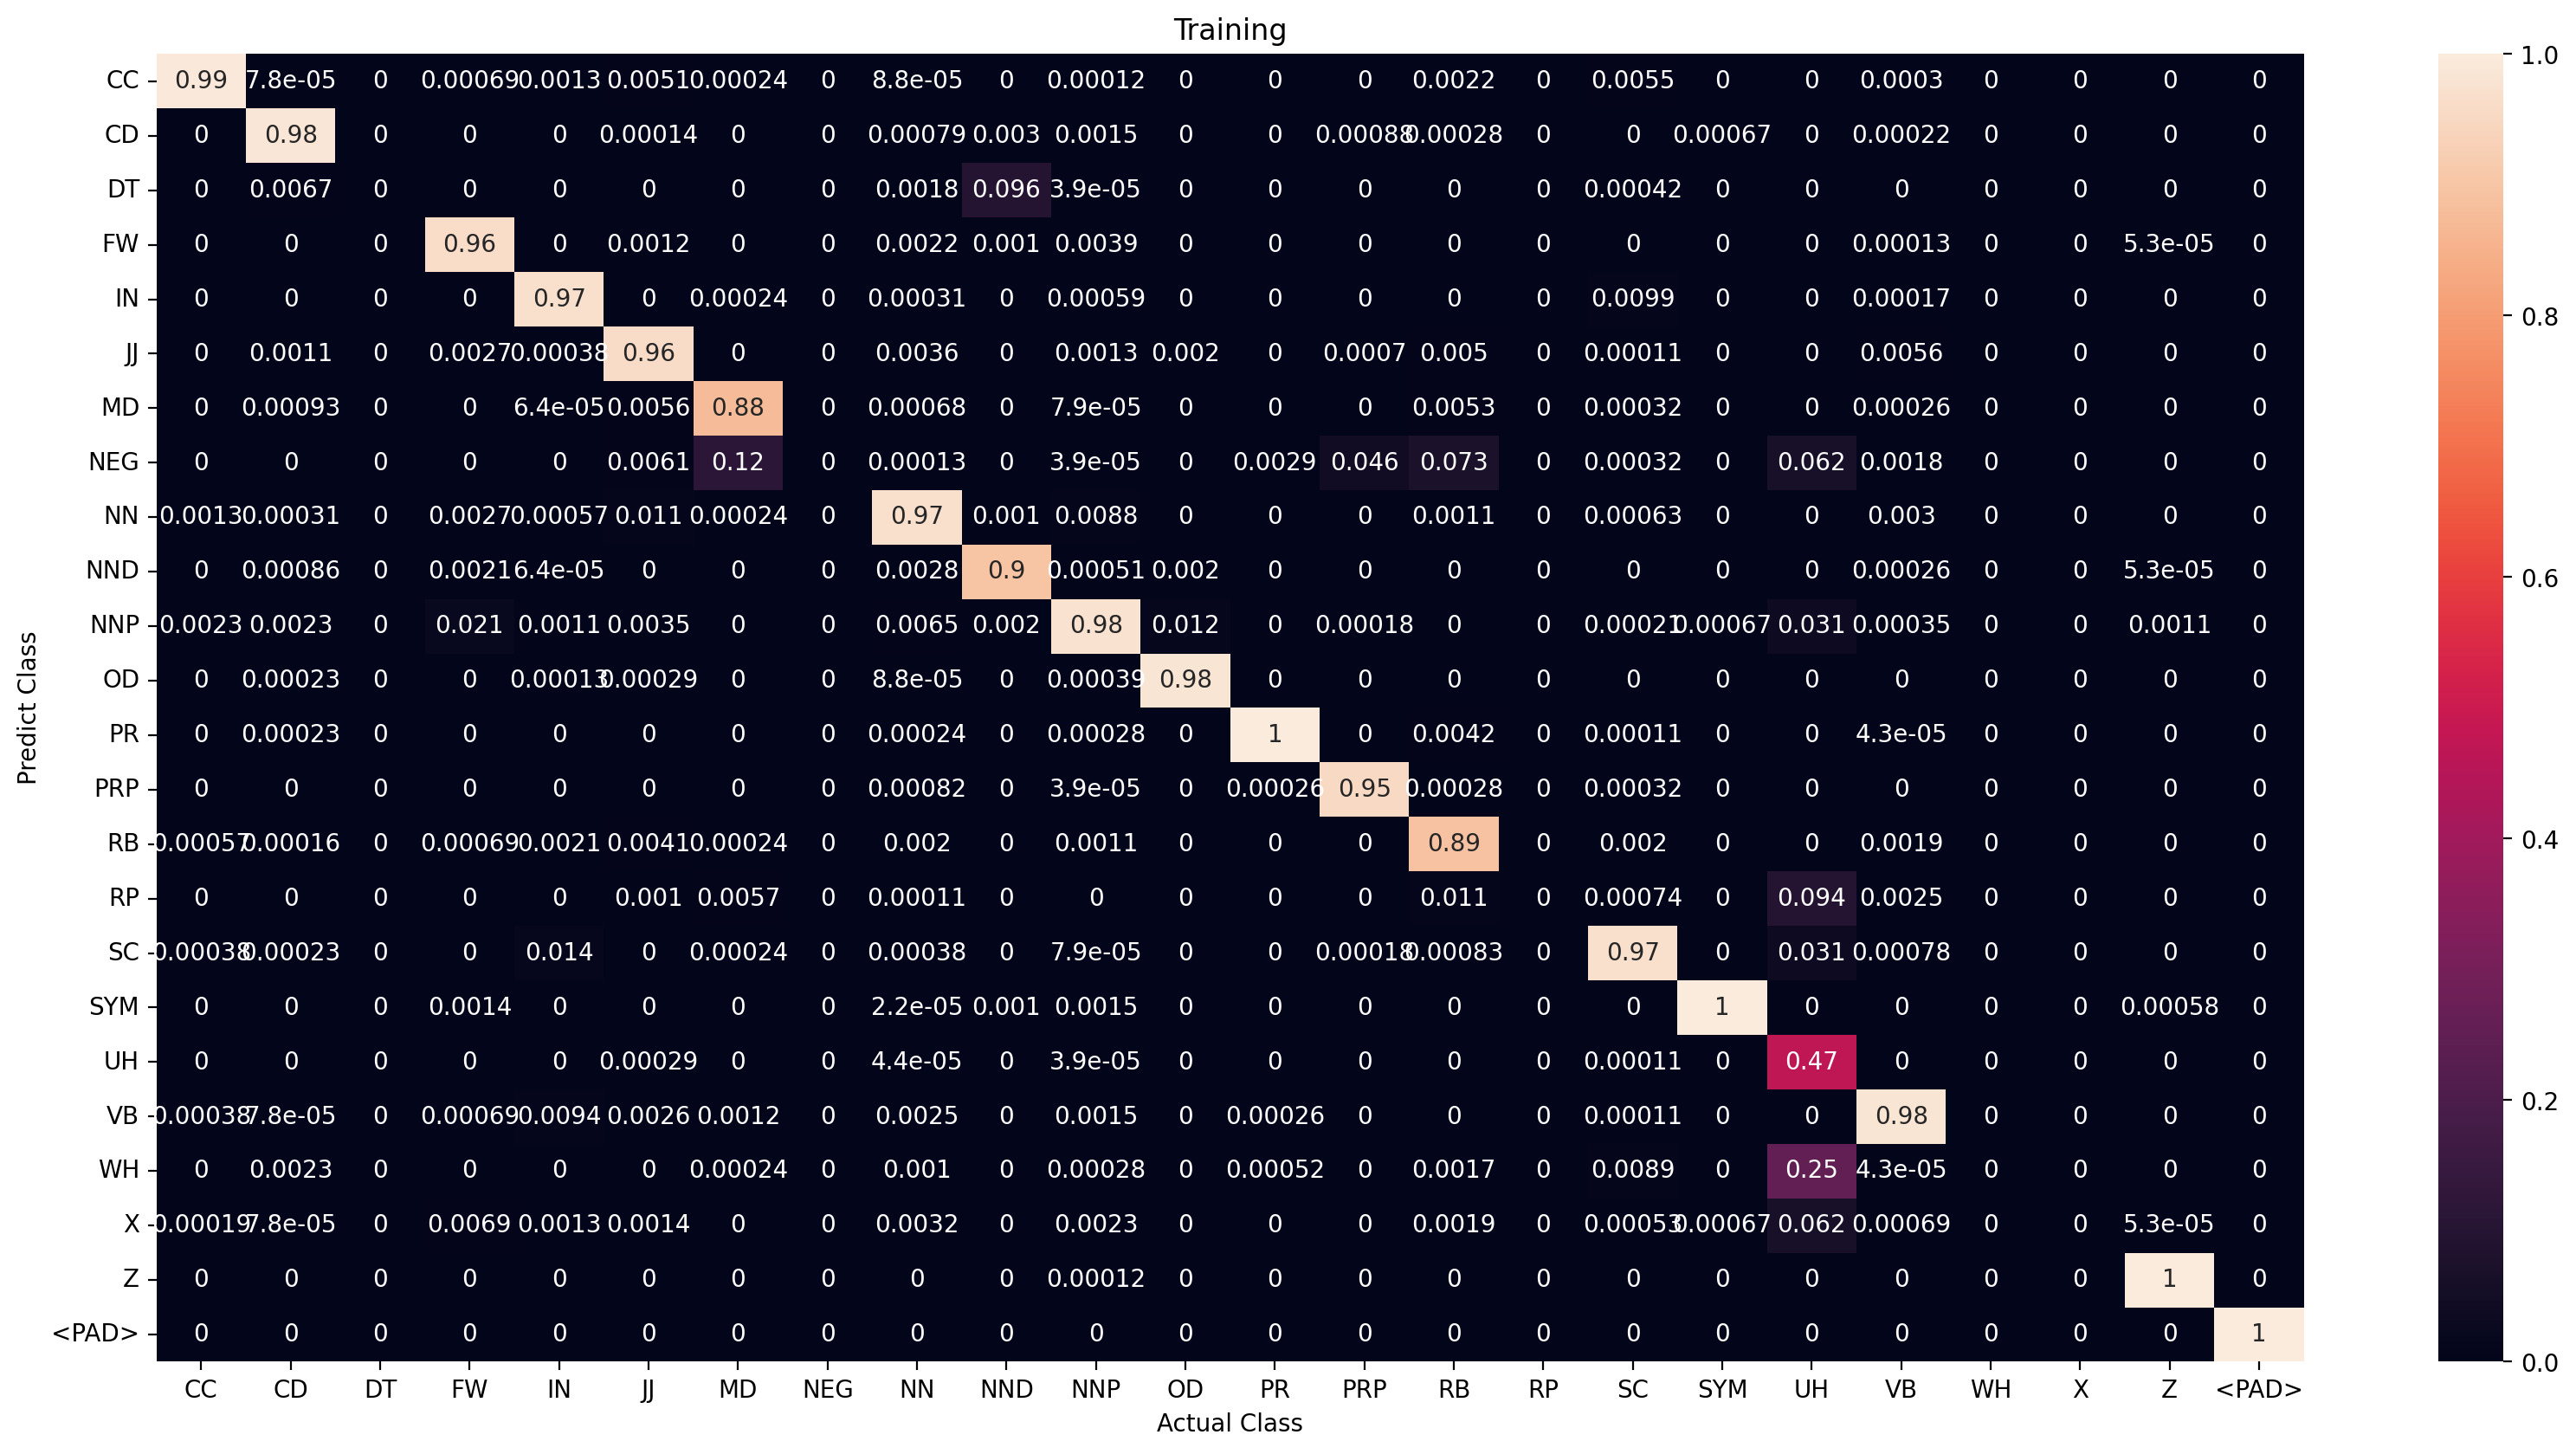

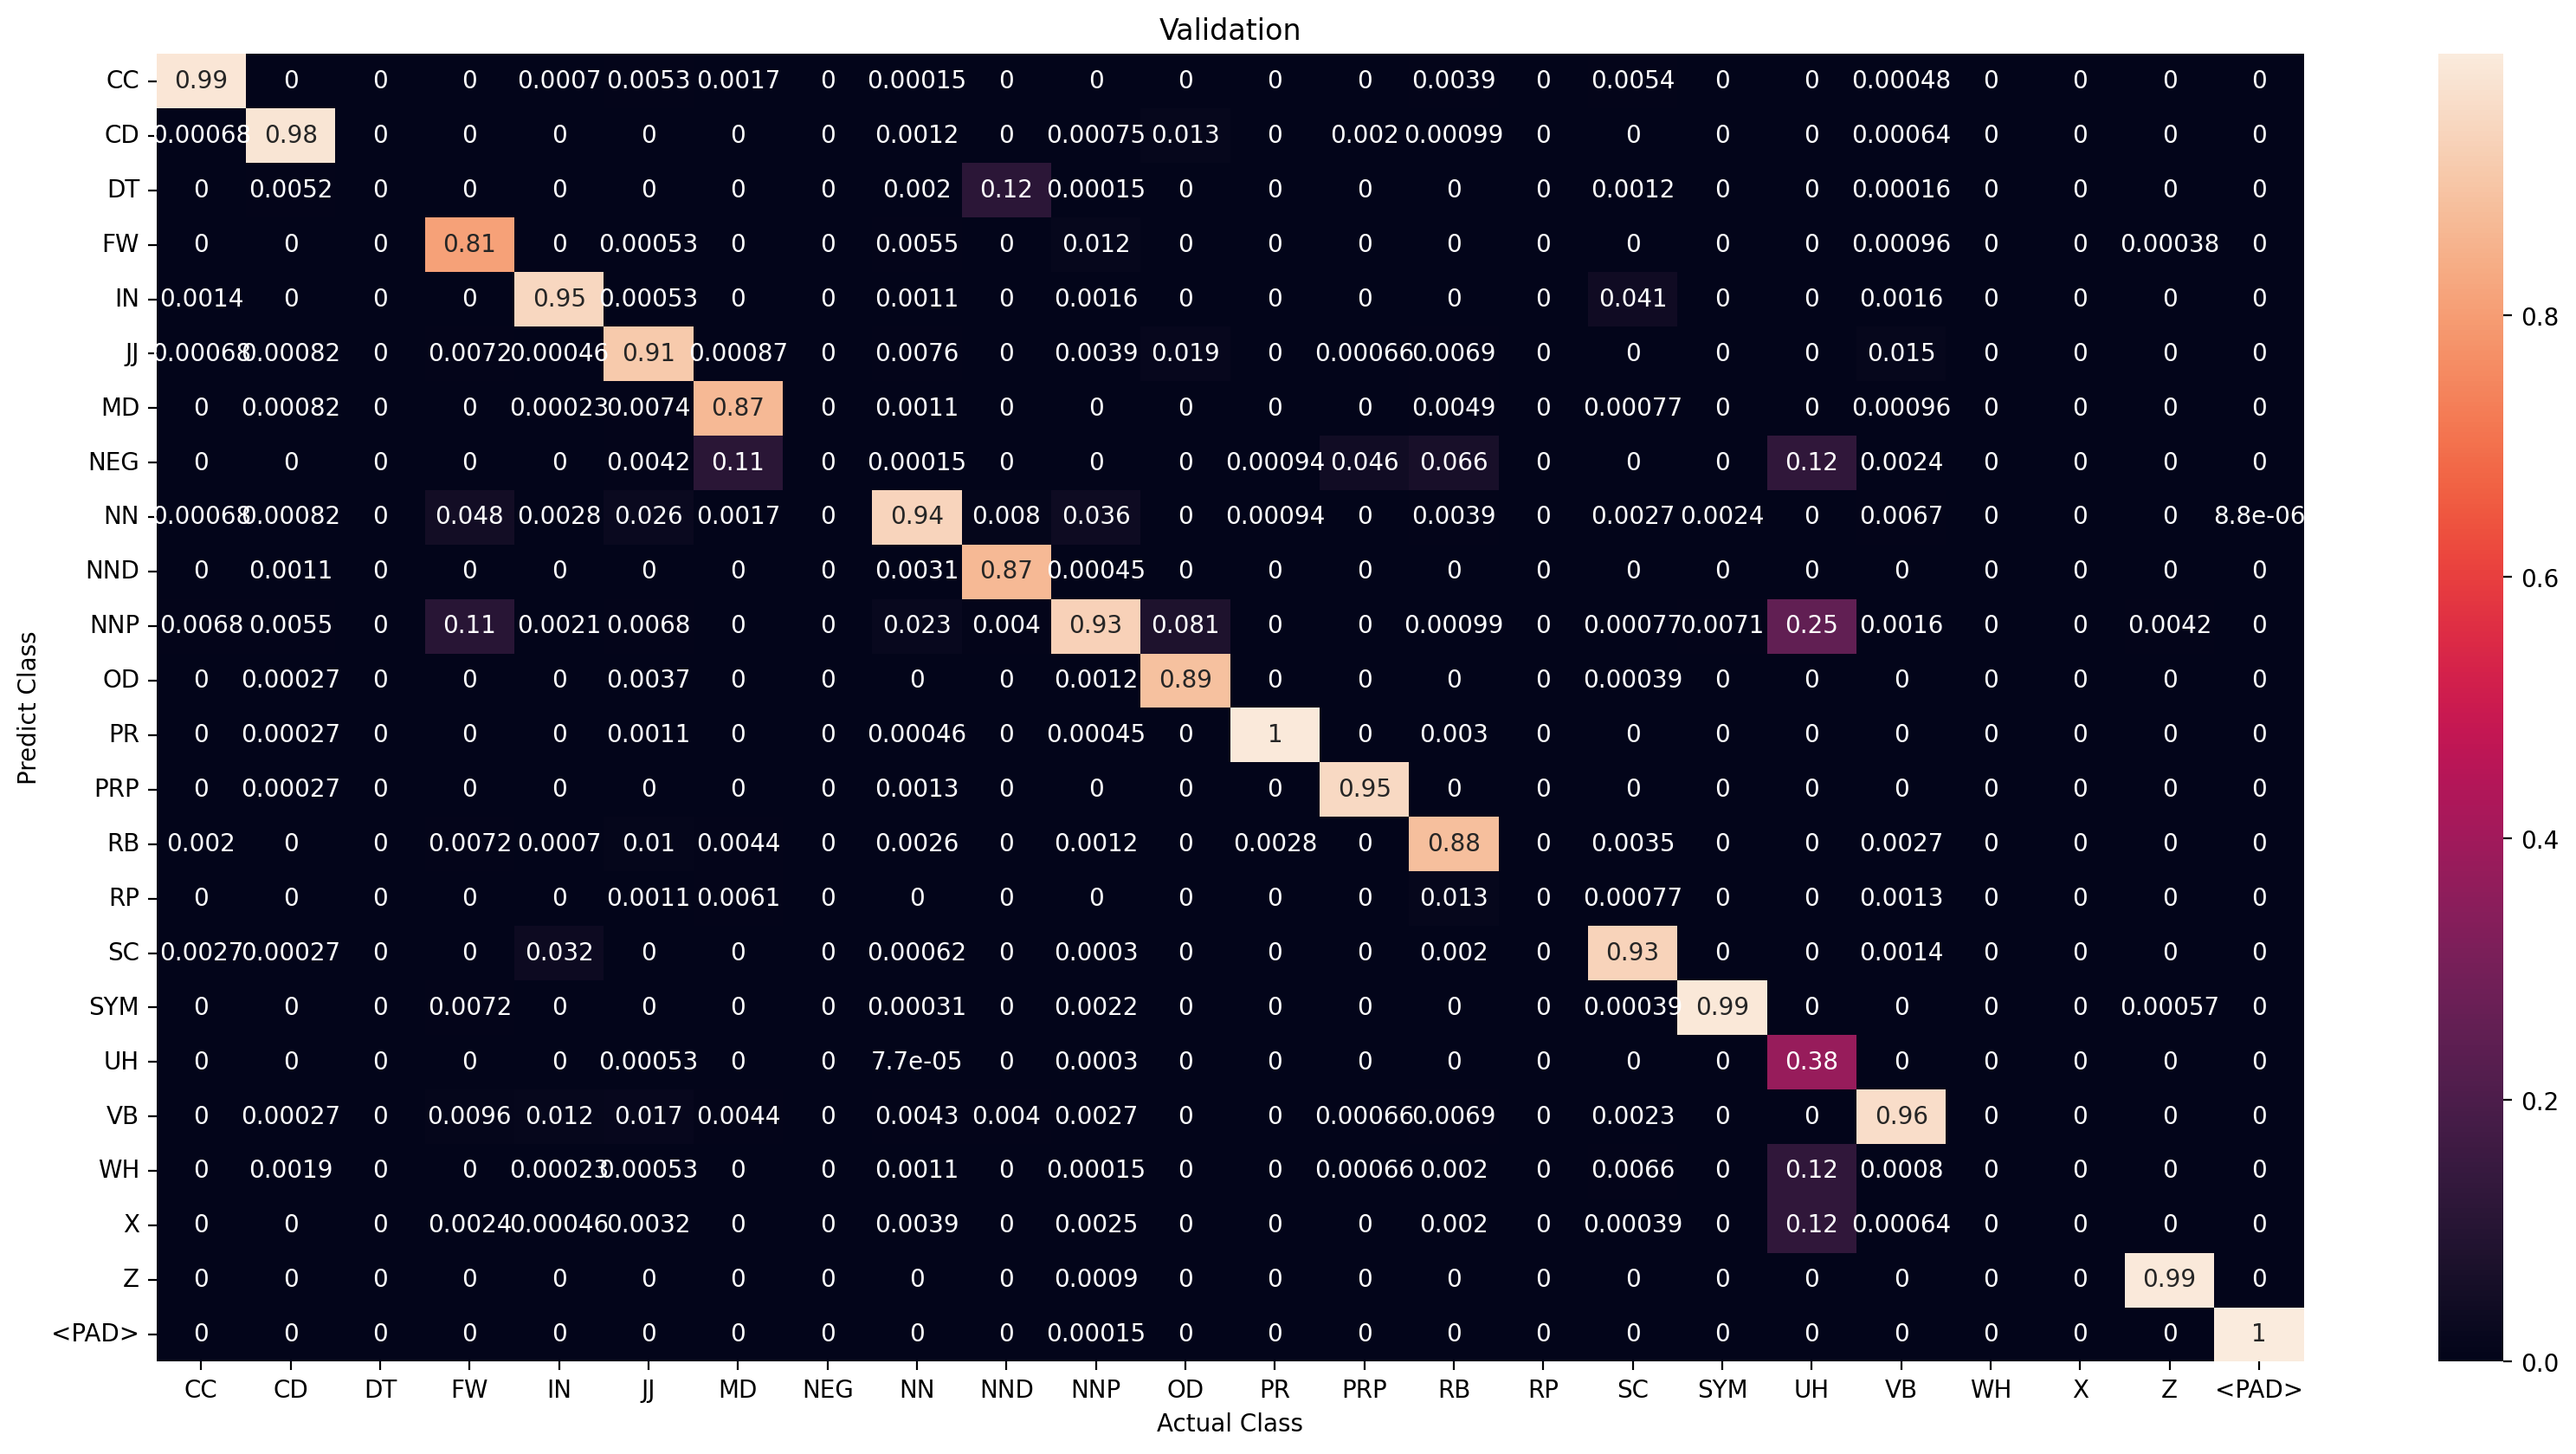

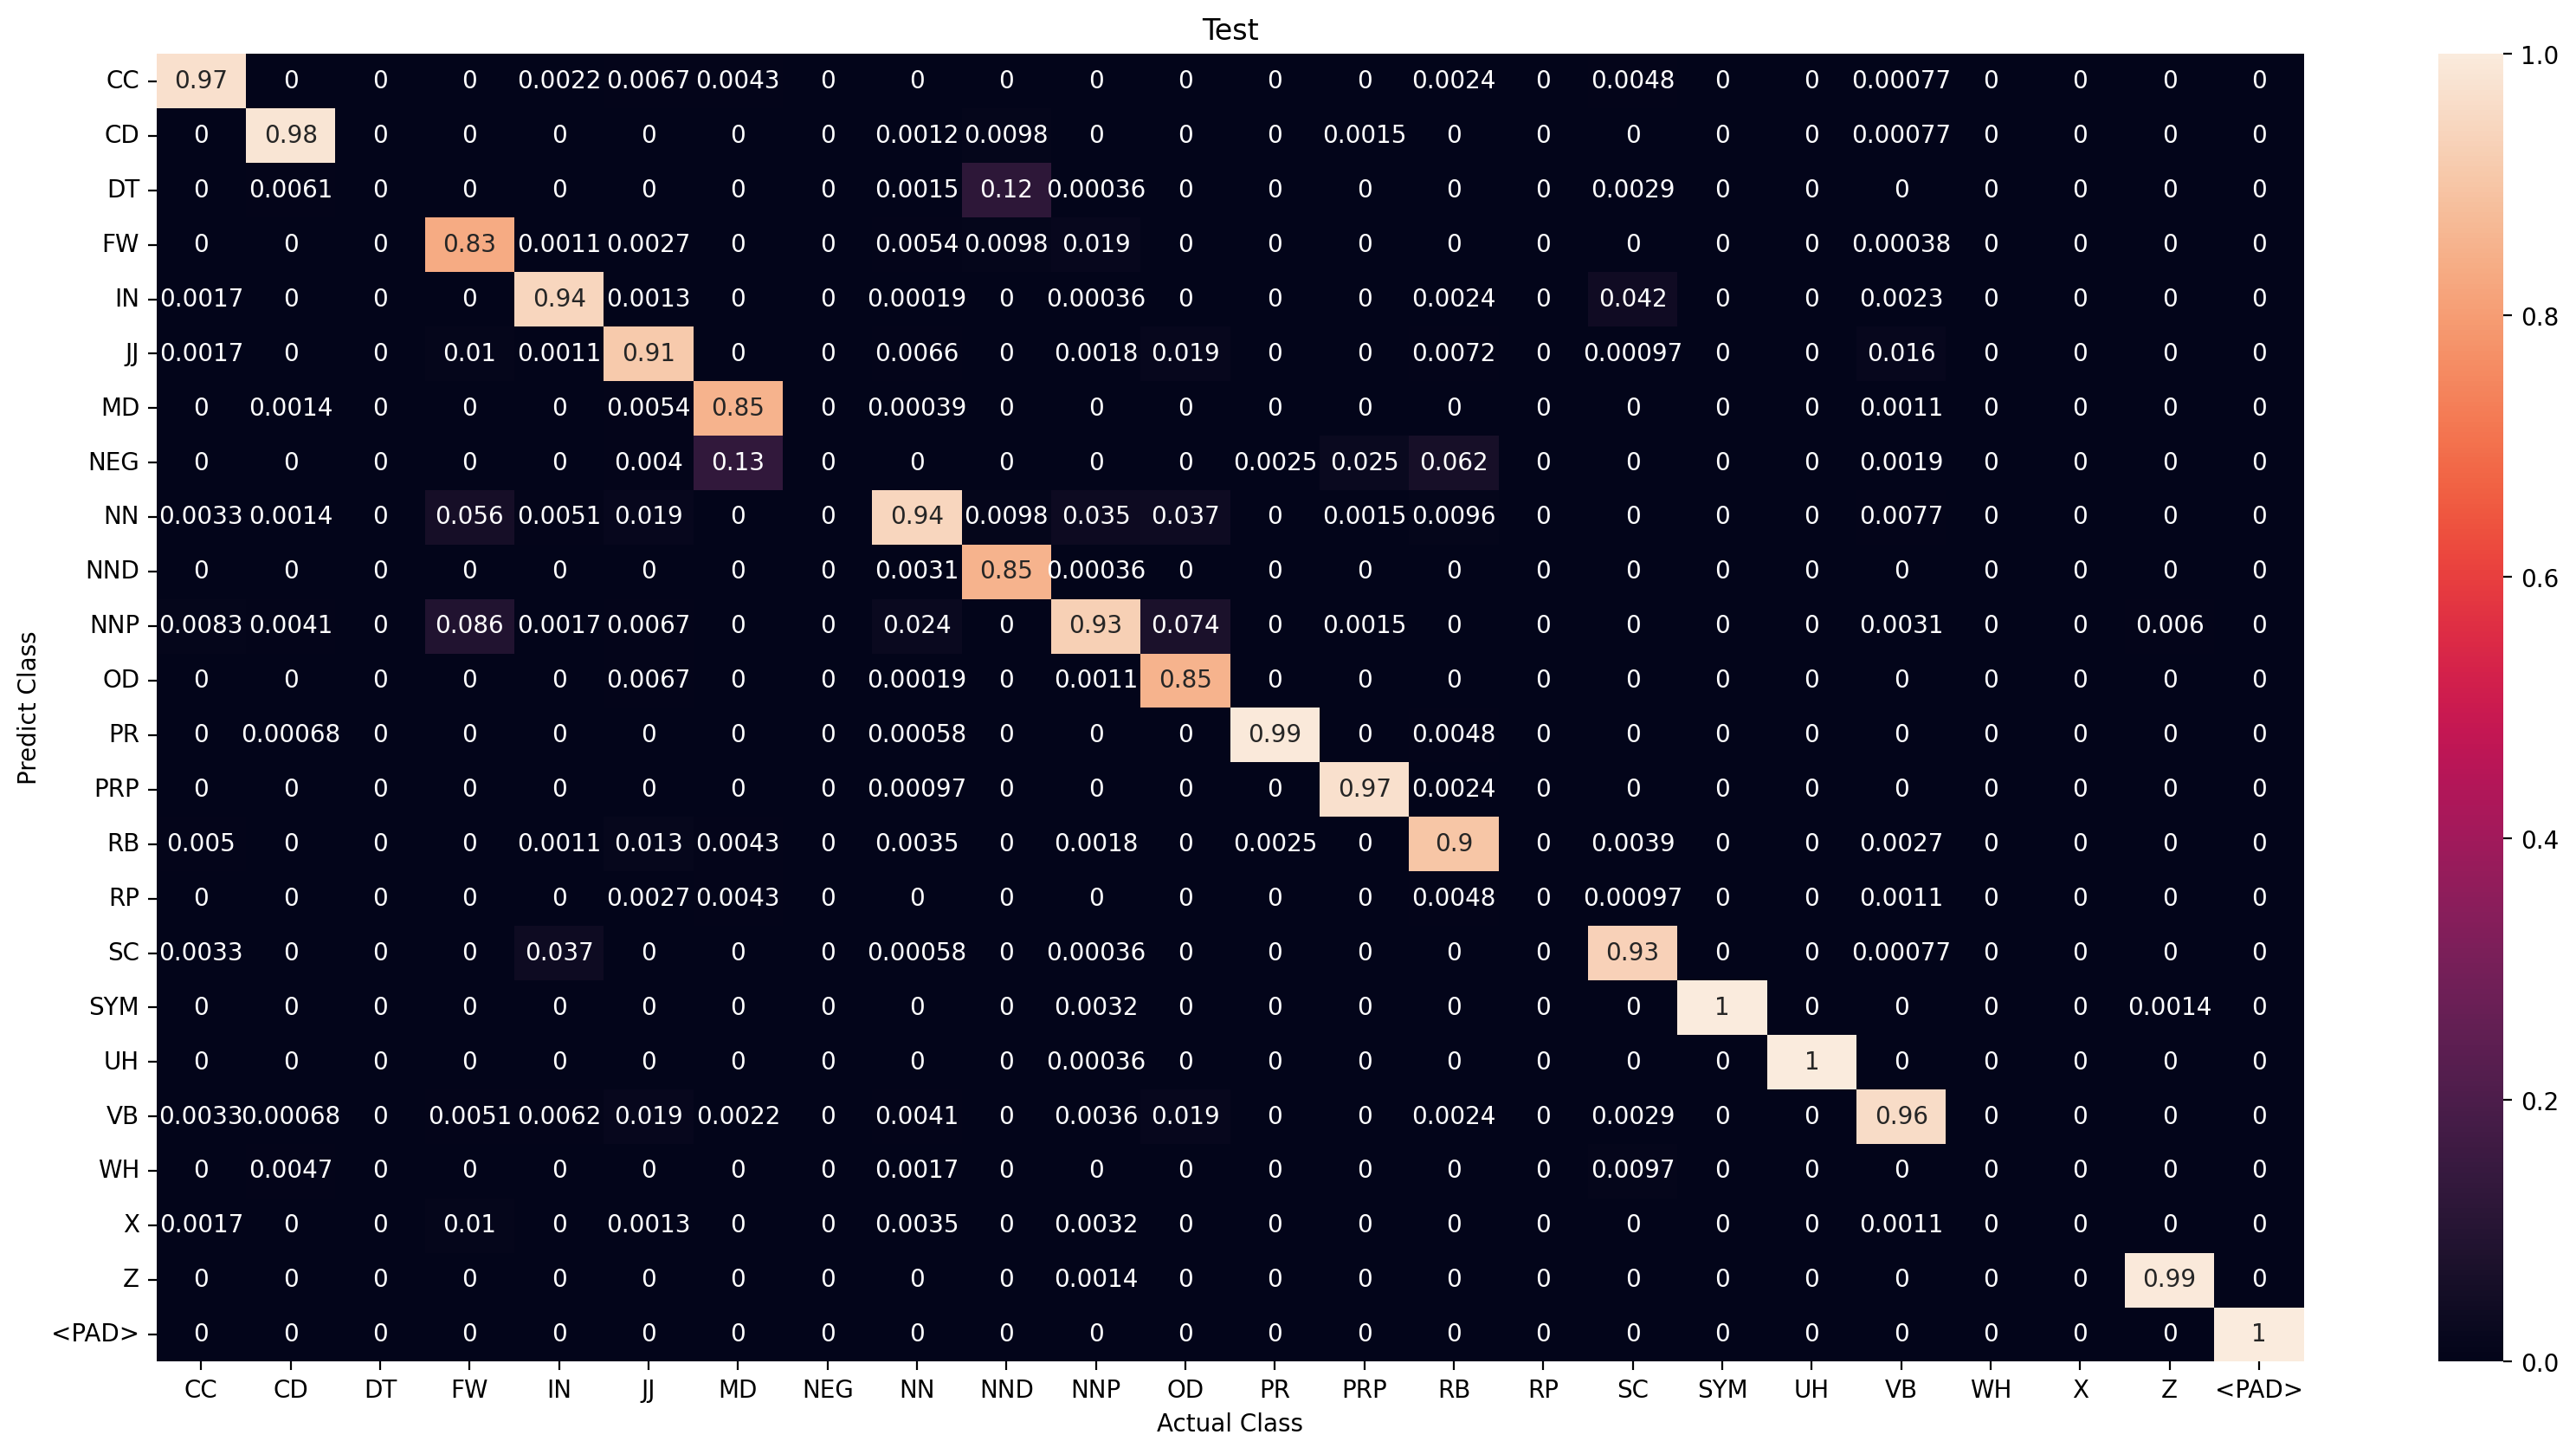

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5214       | CC    : 132      |
| CD    : 12730  | CD    : 12640      | CD    : 90       |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1401       | FW    : 213      |
| IN    : 15342  | IN    : 15214      | IN    : 128      |
| JJ    : 6981   | JJ    : 6612       | JJ    : 369      |
| MD    : 3799   | MD    : 3686       | MD    : 113      |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43967      | NN    : 402      |
| NND   : 1047   | NND   : 885        | NND   : 162      |
| NNP   : 25175  | NNP   : 24725      | NNP   : 450      |
| OD    : 524    | OD    : 503        | OD    : 21       |
| PR    : 3880   | PR    : 3842       | PR    : 38       |
| PRP   : 5471   | PRP   : 5428       | PRP   : 43       |
| RB    : 3477   | RB    : 3228       | RB    : 249      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11165
Wrong prediction            : 641
Percentage correct oov pred : 94.57055734372352

Validation
Number OOV token            : 3366
Correct prediction          : 2984
Wrong prediction            : 382
Percentage correct oov pred : 88.65121806298278

Test
Number OOV token            : 1390
Correct prediction          : 1244
Wrong prediction            : 146
Percentage correct oov pred : 89.49640287769785



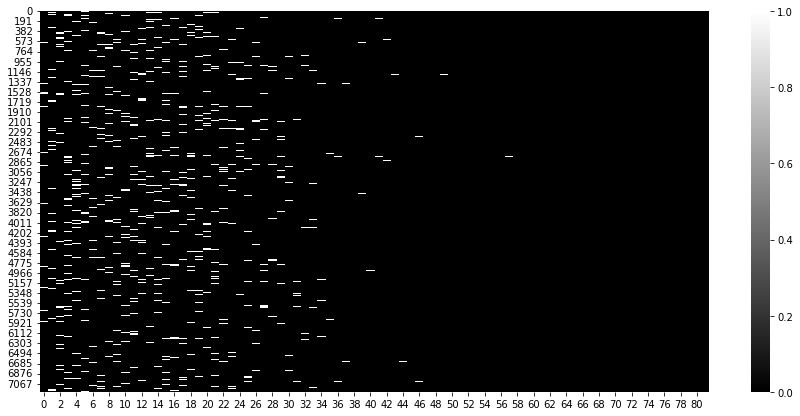

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

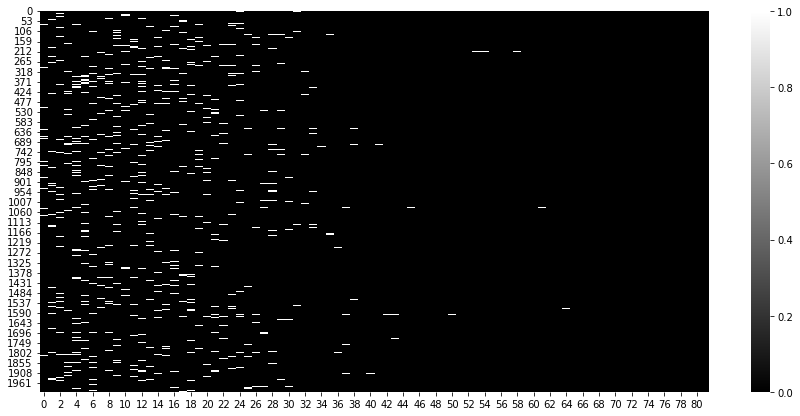

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

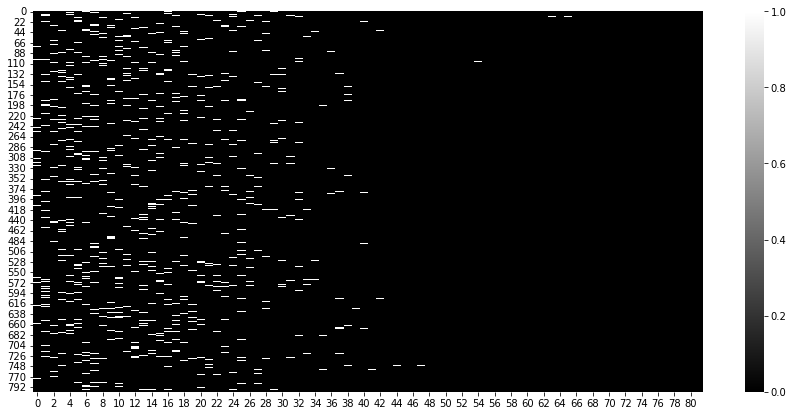

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);